In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Prepare Data set

In [2]:
Data_Base_Path = './datas/UCR_TS_Archive_2015'

In [3]:
import os
flist = [x for x in os.listdir(Data_Base_Path) if os.path.isdir(os.path.join(Data_Base_Path, x))]
flist.sort(key=str.lower)
for index, name in enumerate(flist):
    print("%d: %s"%(index, name))

0: 50words
1: Adiac
2: ArrowHead
3: Beef
4: BeetleFly
5: BirdChicken
6: Car
7: CBF
8: ChlorineConcentration
9: CinC_ECG_torso
10: Coffee
11: Computers
12: Cricket_X
13: Cricket_Y
14: Cricket_Z
15: DiatomSizeReduction
16: DistalPhalanxOutlineAgeGroup
17: DistalPhalanxOutlineCorrect
18: DistalPhalanxTW
19: Earthquakes
20: ECG200
21: ECG5000
22: ECGFiveDays
23: ElectricDevices
24: FaceAll
25: FaceFour
26: FacesUCR
27: FISH
28: FordA
29: FordB
30: Gun_Point
31: Ham
32: HandOutlines
33: Haptics
34: Herring
35: InlineSkate
36: InsectWingbeatSound
37: ItalyPowerDemand
38: LargeKitchenAppliances
39: Lighting2
40: Lighting7
41: MALLAT
42: Meat
43: MedicalImages
44: MiddlePhalanxOutlineAgeGroup
45: MiddlePhalanxOutlineCorrect
46: MiddlePhalanxTW
47: MoteStrain
48: NonInvasiveFatalECG_Thorax1
49: NonInvasiveFatalECG_Thorax2
50: OliveOil
51: OSULeaf
52: PhalangesOutlinesCorrect
53: Phoneme
54: Plane
55: ProximalPhalanxOutlineAgeGroup
56: ProximalPhalanxOutlineCorrect
57: ProximalPhalanxTW
58: Refr

In [4]:
dataset_index = 1
dataset_name = flist[dataset_index]
print(dataset_name)

Adiac


In [5]:
epsilon = 1e-8

In [6]:
def readData(filename):
    data = np.loadtxt(filename, delimiter = ',')
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

In [7]:
X_train, Y_train = readData('%s/%s/%s_TRAIN'%(Data_Base_Path, dataset_name, dataset_name))
X_test, Y_test = readData('%s/%s/%s_TEST'%(Data_Base_Path, dataset_name, dataset_name))
series_length = X_train.shape[1]
nb_classes = len(np.unique(Y_train))
N_train = X_train.shape[0]
N_test = X_test.shape[0]
Y_train = (Y_train - Y_train.min()) / (Y_train.max() - Y_train.min()) * (nb_classes - 1)
Y_test = (Y_test - Y_test.min()) / (Y_test.max() - Y_test.min()) * (nb_classes - 1)

## Normalization
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / (X_train_std + epsilon)
X_test = (X_test - X_train_mean) / (X_train_std + epsilon)

In [8]:
print('''Series length: %d
Classes number: %d
Train set Number: %d
Test set Number: %d'''%(series_length, nb_classes, N_train, N_test))

Series length: 176
Classes number: 37
Train set Number: 390
Test set Number: 391


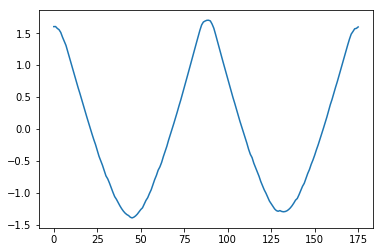

In [9]:
plt.plot(X_train[0,:])

## MFD Layers

In [10]:
import keras
from keras.engine.topology import Layer
import tensorflow as tf

Using TensorFlow backend.


In [11]:
class MRFFT(Layer):
    def compute_output_shape(self,input_shape):
        o_shape=[input_shape]*2
        return o_shape
    def call(self,inputs):
        t=tf.unstack(inputs,axis=2)
        ft=[tf.expand_dims(tf.spectral.rfft(k),-1) for k in t]
        ft=tf.concat(ft,-1)
        ift=tf.imag(ft)
        return [rft,ift]
class MIRFFT(Layer):
    def compute_output_shape(self,input_shape):
        return input_shape[0]
    def call(self,inputs):
        rft=inputs[0]
        ift=inputs[1]
        ft=tf.complex(rft,ift)
        t=tf.unstack(ft,axis=2)
        tt=[tf.expand_dims(tf.spectral.irfft(k),-1) for k in t]
        tt=tf.concat(tt,-1)
        return tt
class MFD_FFT(Layer):
    def __init__(self,in_shape,num_p,**kwargs):
        self.num_p = num_p
        self.in_shape=in_shape
        super(MFD_FFT,self).__init__(**kwargs)
        
    def compute_output_shape(self,input_shape):
        o_shape=input_shape[:2]+(self.num_p,input_shape[-1],)
        return o_shape
    
    def call(self,inputs):
        t=tf.unstack(inputs,axis=2)
        ft=[tf.expand_dims(tf.spectral.rfft(k),-1) for k in t]
        ft=tf.concat(ft,-1)
        fshape=self.in_shape
        
        m=fshape%self.num_p
        if m!=0:
            d=fshape//(self.num_p-1)
            _m=fshape%(self.num_p-1)
            if _m==0:
                _d=fshape//self.num_p-1
                _m1=fshape-_d*(self.num_p-1)
        else:
            d=fshape//self.num_p
        if m!=0:
            if _m==0:
                sp=tf.split(ft,[_d for _ in range(self.num_p-1)]+[_m1,],axis=1)
            else:
                sp=tf.split(ft,[d for _ in range(self.num_p-1)]+[_m,],axis=1)
        else:
            sp=tf.split(ft,[d for _ in range(self.num_p)],axis=1)
            
        at=None
        for i in range(self.num_p):
            t=None
            for k in range(self.num_p):
                if i!=k:
                    tp=sp[k]*0.
                else:
                    tp=sp[k]*1.
                if t is None:
                    t=tp
                else:
                    t=tf.concat([t,tp],1)
                    
            s=t
            ts=tf.unstack(s,axis=2)
            ts=[tf.expand_dims(tf.spectral.irfft(k),-1) for k in ts]
            s=tf.concat(ts,-1)
            if at is None:
                at=tf.expand_dims(s,2)
            else:
                at=tf.concat([at,tf.expand_dims(s,2)],2)
        return at

## Build Network Model

In [21]:
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import Input, Activation, GlobalAveragePooling2D
from keras.layers import Dense,Conv1D, Conv2D, BatchNormalization
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import logging

In [13]:
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))
Y_train = to_categorical(Y_train, nb_classes)
Y_test = to_categorical(Y_test, nb_classes)

In [14]:
## model
input_x = Input(shape = (series_length, 1))
y = Conv1D(64, kernel_size=8, padding='same', kernel_initializer='he_uniform', 
           kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(input_x)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = MFD_FFT(in_shape=series_length//2+1, num_p=6)(y)
y = BatchNormalization()(y)
y = Conv2D(128, kernel_size=(5,1), padding='same', kernel_initializer='he_uniform', 
           kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv2D(256, kernel_size=(3,6), kernel_initializer='he_uniform', 
           kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = GlobalAveragePooling2D()(y)
output_y = Dense(nb_classes, activation='softmax', 
                 kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3))(y)

model = Model(input_x, output_y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 176, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 176, 64)           576       
_________________________________________________________________
batch_normalization_1 (Batch (None, 176, 64)           256       
_________________________________________________________________
activation_1 (Activation)    (None, 176, 64)           0         
_________________________________________________________________
mfd_fft_1 (MFD_FFT)          (None, 176, 6, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 176, 6, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 6, 128)       41088     
__________

In [15]:
def MPCE(y_true,y_pred):
    C={}
    for k in y_true:
        if k in C.keys():
            C[k]+=1
        else:
            C[k]=1
    loss=0
    for i in range(len(y_true)):
        if y_true[i]!=y_pred[i]:
            loss+=(1/C[y_true[i]])
    loss/=nb_classes
    return loss

In [16]:
class MPCECallback(Callback):
    def on_epoch_end(self,epoch,logs=None):
        y_pred=np.argmax(self.model.predict(X_test),axis=1)
        y_t=np.argmax(y_test,axis=1)
        l=MPCE(y_t,y_pred)
        logs['MPCE']=l
class HistoryLogger(Callback):
    def on_train_begin(self,logs=None):
        logging.warning('Begin Training............')
        self.best_acc=0.0
        self.best_mpce=1.0
    def on_epoch_end(self,epoch,logs=None):
        loss=logs['loss']
        acc=logs['acc']*100
        val_loss=logs['val_loss']
        val_acc=logs['val_acc']*100
        mpce=logs['MPCE']
        if val_acc>=self.best_acc:
            self.best_acc=val_acc
        if mpce<=self.best_mpce:
            self.best_mpce=mpce
        logging.info('%4d - over - loss: %.4f, acc: %.2f | val_loss: %.4f, val_acc: %.2f, MPCE:%.4f | best_acc: %.2f, best_mpce:%.4f'%(epoch,loss,acc,val_loss,val_acc,mpce,self.best_acc,self.best_mpce))
    def on_train_end(self,logs=None):
        logging.warning('End Training............')

In [17]:
model_checkpoint = ModelCheckpoint('./weights/%s_weights.h5' % dataset_name, 
                                   verbose=1, monitor='val_acc', save_best_only=True, 
                                   save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=30, mode='auto', 
                              factor=1.0/np.cbrt(2), cooldown=0, min_lr=1e-5, verbose=1)
callback_list = [model_checkpoint, reduce_lr, MPCECallback(), HistoryLogger()]

## Train

In [18]:
epochs = 2000
batch_size = 20
learning_rate = 1e-3

In [19]:
optim = Adam(lr=learning_rate)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, callbacks=callback_list, 
                 verbose=1, validation_data=(X_test, Y_test))

Train on 390 samples, validate on 391 samples
Epoch 1/2000
